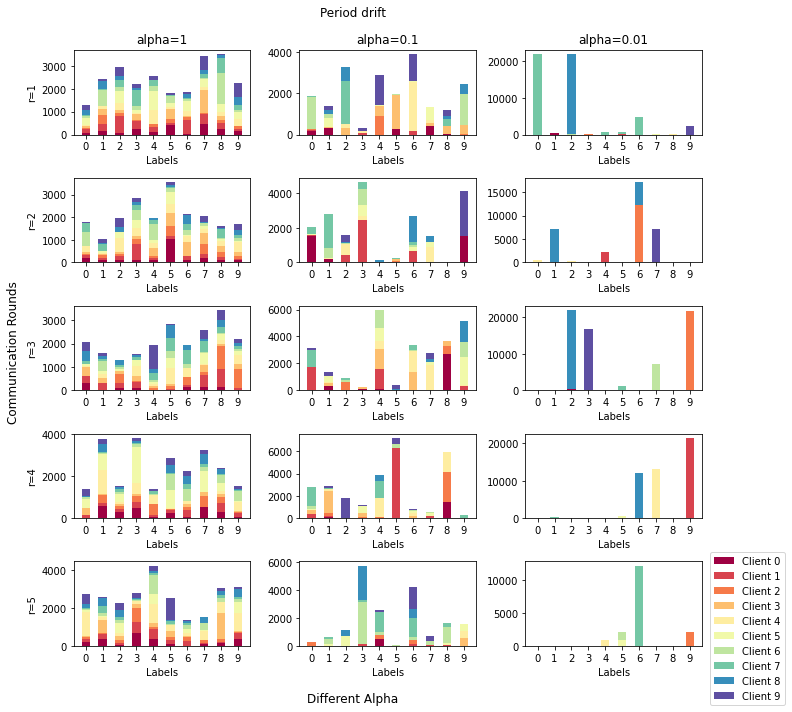

In [12]:
import torch
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from torchvision import datasets
import numpy as np
# np.random.seed(42)


def dirichlet_split_noniid(train_labels, alpha, n_clients):
    '''
    参数为alpha的Dirichlet分布将数据索引划分为n_clients个子集
    '''
    n_classes = train_labels.max()+1
    label_distribution = np.random.dirichlet([alpha]*n_clients, n_classes)
    # (K, N)的类别标签分布矩阵X，记录每个client占有每个类别的多少

    class_idcs = [np.argwhere(train_labels == y).flatten()
                  for y in range(n_classes)]
    # 记录每个K个类别对应的样本下标

    client_idcs = [[] for _ in range(n_clients)]
    # 记录N个client分别对应样本集合的索引
    for c, fracs in zip(class_idcs, label_distribution):
        # np.split按照比例将类别为k的样本划分为了N个子集
        # for i, idcs 为遍历第i个client对应样本集合的索引
        for i, idcs in enumerate(np.split(c, (np.cumsum(fracs)[:-1]*len(c)).astype(int))):
            client_idcs[i] += [idcs]

    client_idcs = [np.concatenate(idcs) for idcs in client_idcs]

    return client_idcs


# torch.manual_seed(42)

if __name__ == "__main__":

    N_CLIENTS = 100
    DIRICHLET_ALPHA = 0.1

    train_data = datasets.EMNIST(
        root=".", split="digits", download=True, train=True)
    test_data = datasets.EMNIST(
        root=".", split="digits", download=True, train=False)
    n_channels = 1

    input_sz, num_cls = train_data.data[0].shape[0],  len(train_data.classes)

    train_labels = np.array(train_data.targets)

    # matplotlib.rcParams['text.usetex'] = True
    cmap = 'Spectral'
    # plt.style.use("seaborn-dark")
    color = plt.get_cmap(cmap)(np.linspace(0, 1, 10))
    n=5
    alpha=[1,0.1,0.01]
    # 展示不同client的不同label的数据分布
    fig, ax = plt.subplots(n,3, figsize=(10, 10))
    # fig.set_label('aaa')
    for r in range(3):
        DIRICHLET_ALPHA=alpha[r]
        # 我们让每个client不同label的样本数量不同，以此做到Non-IID划分
        client_idcs = dirichlet_split_noniid(
            train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)
        g = []
        for i in range(10):
            np.random.shuffle(client_idcs)
            g.append(client_idcs[0:10])
        for i in range(n):
            # ax[i].figure(figsize=(20, 3))
            # ax[i][r].set_ylim(1969.5, 2011.1)
            ax[i][r].hist([train_labels[idc]for idc in g[i]], stacked=True,
                bins=np.arange(min(train_labels)-0.5, max(train_labels) + 1.5, 1),
                    label=["Client {}".format(j) for j in range(N_CLIENTS)], rwidth=0.5,color=color)
            # ax[i].legend()
            ax[i][r].set_xticks(np.arange(num_cls))
            # ax[i][r].set_title('r={}, alpha={}'.format(r+1,alpha[r]))
            ax[i][r].set_xlabel('Labels')
            # ax[i][r].set_ylabel('num of samples')
            # ax[0][i].set_title(key)
            # ax[0][i].set_xlabel('Rounds')
            # ax[0][i].set_ylabel(key)
            ax[i][0].set_ylabel('r={}'.format(i+1))
            ax[0][r].set_title('alpha={}'.format(alpha[r]))
    lines, labels = ax[i][r].get_legend_handles_labels()
    
    fig.supxlabel('Different Alpha')
    fig.supylabel('Communication Rounds')
    fig.legend(lines, labels, loc=4, bbox_to_anchor=(
        1.1, 0.01), borderaxespad=0., mode=None)
    fig.tight_layout()
    fig.suptitle('Period drift') 
    fig.subplots_adjust(top=0.92)
    fig.savefig('period_drift.pdf', bbox_inches = 'tight')
    
    


In [14]:
len(test_data)

40000

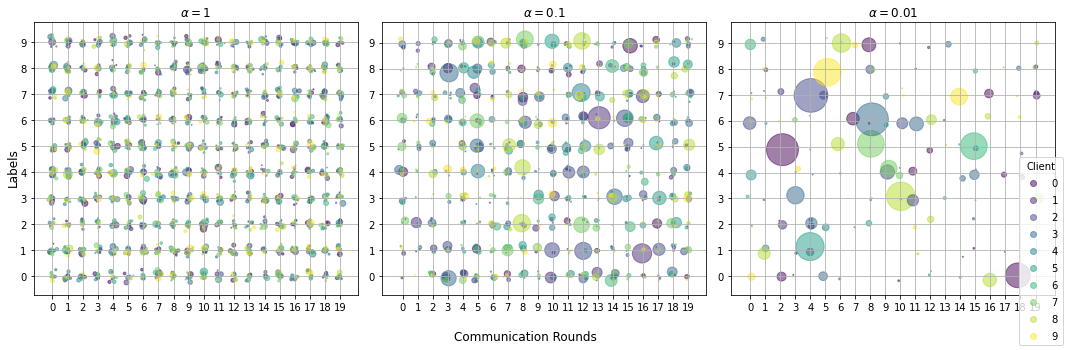

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from collections import Counter
import torch
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from torchvision import datasets
import numpy as np
from data import *
N_CLIENTS = 3400
DIRICHLET_ALPHA = 1

with h5py.File('./data_in_use/femnist.h5', 'r') as f:
    train_data, test_data = f['train'][:], f['test'][:]
    train_data[train_data['label'] < 10]


num_cls = 10

train_labels = np.array(train_data['label'])
client_idcs = dirichlet_split_noniid(
    train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)

g = {}
rounds=20
num_clients=10
num_labels=10

fig, ax = plt.subplots(1,3, figsize=(15, 5))
# fig.set_label('aaa')
alpha = [1, 0.1, 0.01]

for f in range(3):
    DIRICHLET_ALPHA = alpha[f]
    # 我们让每个client不同label的样本数量不同，以此做到Non-IID划分
    client_idcs = dirichlet_split_noniid(
        train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)
    r = []
    client = []
    label = []
    sample_num = []
    for i in range(rounds):
        np.random.shuffle(client_idcs)
        g = client_idcs[:num_clients]
        for j in range(num_labels):
            for k in range(num_clients):
                cnt=Counter(train_labels[g[k]])
                r += [i]
                label += [j]
                client += [k]
                sample_num += [cnt[j]]
    scale=0.1
    r = np.array(r)+np.random.normal(loc=0.0, scale=scale, size=len(r))
    label = np.array(label)+np.random.normal(loc=0.0, scale=scale, size=len(label))
    scatter=ax[f].scatter(r, label, c=client, s=sample_num, alpha=0.5)
    ax[f].set_xticks(np.arange(rounds))
    ax[f].set_yticks(np.arange(num_cls))
    # ax[f].set_xlabel('communication rounds')
    # ax[f].set_ylabel('Labels')
    ax[f].set_title(r'$\alpha={}$'.format(DIRICHLET_ALPHA))
    ax[f].grid(True)
fig.legend(*scatter.legend_elements(),
                    loc="lower right", title="Client")
fig.tight_layout()
# lines, labels = ax[-1].get_legend_handles_labels()

fig.supylabel('Labels')
fig.supxlabel('Communication Rounds')
# fig.legend(legend)
fig.tight_layout()
fig.suptitle('')
fig.subplots_adjust(top=0.9)
fig.savefig('noniid.pdf', bbox_inches='tight')

plt.show()


In [28]:
labels

[]

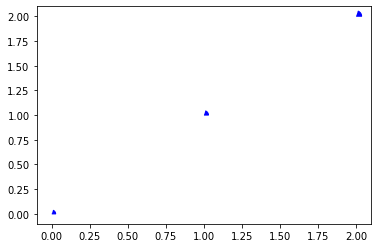

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# first define the ratios
r1 = 0.2       # 20%
r2 = r1 + 0.4  # 40%

# define some sizes of the scatter marker
sizes = np.array([60, 80, 120])

# calculate the points of the first pie marker
# these are just the origin (0, 0) + some (cos, sin) points on a circle
x1 = np.cos(2 * np.pi * np.linspace(0, r1))
y1 = np.sin(2 * np.pi * np.linspace(0, r1))
xy1 = np.row_stack([[0, 0], np.column_stack([x1, y1])])
s1 = np.abs(xy1).max()

x2 = np.cos(2 * np.pi * np.linspace(r1, r2))
y2 = np.sin(2 * np.pi * np.linspace(r1, r2))
xy2 = np.row_stack([[0, 0], np.column_stack([x2, y2])])
s2 = np.abs(xy2).max()

x3 = np.cos(2 * np.pi * np.linspace(r2, 1))
y3 = np.sin(2 * np.pi * np.linspace(r2, 1))
xy3 = np.row_stack([[0, 0], np.column_stack([x3, y3])])
s3 = np.abs(xy3).max()

fig, ax = plt.subplots()
ax.scatter(range(3), range(3), marker=xy1, s=s1**2 * sizes, facecolor='blue')
# ax.scatter(range(3), range(3), marker=xy2, s=s2**2 * sizes, facecolor='green')
# ax.scatter(range(3), range(3), marker=xy3, s=s3**2 * sizes, facecolor='red')

plt.show()


In [85]:
xy1

array([[0.        , 0.        ],
       [1.        , 0.        ],
       [0.99967117, 0.02564284],
       [0.99868489, 0.05126882],
       [0.99704181, 0.07686108],
       [0.99474302, 0.1024028 ],
       [0.99179001, 0.12787716],
       [0.98818475, 0.15326743],
       [0.98392959, 0.17855689],
       [0.97902733, 0.20372893],
       [0.97348121, 0.22876698],
       [0.96729486, 0.25365458],
       [0.96047236, 0.27837536],
       [0.95301819, 0.30291307],
       [0.94493726, 0.32725156],
       [0.93623487, 0.35137482],
       [0.92691676, 0.375267  ],
       [0.91698904, 0.39891239],
       [0.90645826, 0.42229542],
       [0.89533133, 0.44540072],
       [0.88361558, 0.4682131 ],
       [0.8713187 , 0.49071755],
       [0.85844879, 0.51289928],
       [0.84501431, 0.53474369],
       [0.8310241 , 0.55623642],
       [0.81648735, 0.57736333],
       [0.80141362, 0.59811053],
       [0.78581284, 0.61846438],
       [0.76969525, 0.63841148],
       [0.75307147, 0.65793873],
       [0.